In [1]:
import altair as alt
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import shapely.geometry
from shapely.geometry import shape,Point,MultiPolygon
from shapely.geometry.polygon import Polygon
from shapely.ops import cascaded_union
import json
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
from random import randint
import utils
import pyowm
from datetime import datetime
from datetime import timedelta
import datetime as dt
import forecastio
from io import StringIO

# In this notebook we localize a group of sensors of type sds011 in Berlin, we find their closest weather station and we show the distribution of them in the Berlin neighborhood map

## Credentials for pyowm and forecastio are needed

In [2]:
credentials_1 = pyowm.OWM('48dae982f9e685eee268e90dafba5041')
credentials_2 = "677e17ccb348e07d52486ae3857a2d84"
forecastio_api_key_2 = "fbb446671b7ea5471c62fe799748f099"

## A parquet file with the sensor data is loaded and unique sensor id's are extracted

In [3]:
parquet_file = pq.ParquetFile('../data/raw/parquet/2019-04/sds011/part-00000-18b6bc00-8426-4900-851e-b650c25b6cee-c000.snappy.parquet')

In [4]:
chunks = []
for i in range(parquet_file.num_row_groups):
    current_data = parquet_file.read_row_group(i).to_pandas()
    chunks.append([current_data.loc[:,['sensor_id','lon','lat']]])

In [5]:
sensor_summ=[]
sensor_deff=[]
sensor_list=[]
for i in chunks:
    t=np.asarray(i[0])
    t_u=np.unique(t,axis=0)
    sensor_summ.append(t_u)
    
for s in sensor_summ:
    s_t=np.asarray(s)
    s_u=np.unique(s_t,axis=0)
    sensor_deff.extend([s_u])
    unique_sensor_list=np.asarray(sensor_deff)

for x in unique_sensor_list:
    for i in x:
        sensor_list.extend([i])
d_l=np.asarray(sensor_list)
d_l=np.unique(sensor_list,axis=0)

In [6]:
valid_sensors=d_l[np.where(np.isnan(d_l[:,0])==True,False,True)]

In [8]:
lat_lon=valid_sensors[:,1:3]

## We load the geojason files for Berlin

In [9]:
with open("../data/berlinbezirkt.geojson", "r") as read_file:
    bezirkt_grenzen = json.load(read_file)

In [10]:
with open("../data/lor_ortsteile.geojson", "r") as read_file:
    bezirkt_regionen = json.load(read_file)

In [11]:
bezirkt_geo=bezirkt_grenzen["features"]

In [12]:
bezirkt_reg_geo=bezirkt_regionen["features"]

In [13]:
bezirkt_shapes=[]
for bezirkt in bezirkt_geo:
    bezirkt_shapes.append([bezirkt["properties"]["Gemeinde_name"],shape(bezirkt["geometry"])])

In [14]:
bezirkt_reg_shapes=[]
for bezirkt in bezirkt_reg_geo:
    bezirkt_reg_shapes.append([bezirkt["properties"]["spatial_alias"],shape(bezirkt["geometry"])])

## We assert if a sensor coordinates match any neighborhood in Berlin

In [15]:
berlin_sensors=[]
for point in valid_sensors:
    p=point[1:3]
    p=Point(p)
    for bezirkt in bezirkt_reg_shapes:
        if bezirkt[1].contains(p):
            berlin_sensors.append([point[0],point[1],point[2],bezirkt[0],p])

## We create lists of geometries to plot the sensors on the Berlin map

In [16]:
points=[]
for i in berlin_sensors:
    points.extend([i[4]])

In [17]:
berlin_bezirktregionen_polygons=[]
for polygon in bezirkt_reg_shapes:
    berlin_bezirktregionen_polygons.extend([polygon[1]])

In [18]:
berlin_bezirkt_polygons=[]
for polygon in bezirkt_shapes:
    berlin_bezirkt_polygons.extend([polygon[1]])

In [19]:
berlin_geo = cascaded_union(berlin_bezirkt_polygons)

In [20]:
sensor_x=[]
sensor_y=[]
for sensor in points:
    sensor_x.append(sensor.x)
    sensor_y.append(sensor.y)

# We create a map displaying sensors in Berlin localities

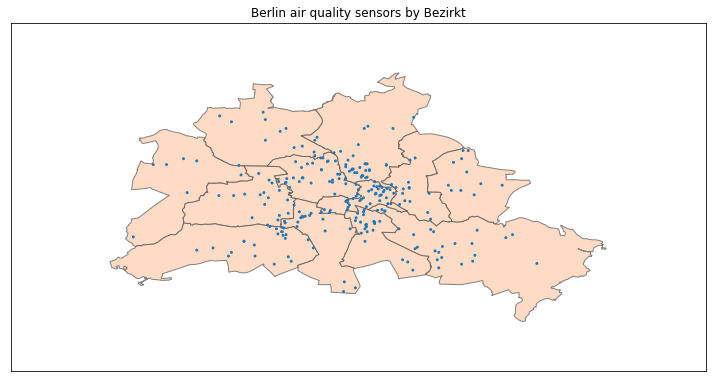

In [21]:
cm = plt.get_cmap('Pastel2')
#num_colours = len(berlin_geo)
 
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = berlin_geo.bounds
w, h = maxx - minx, maxy - miny
ax.set_xlim(minx - 0.2 * w, maxx + 0.2 * w)
ax.set_ylim(miny - 0.2 * h, maxy + 0.2 * h)
ax.set_aspect(1)

bezirkt_patches = []
for p in berlin_bezirkt_polygons:
    colour = cm(1)
    bezirkt_patches.append(PolygonPatch(p, fc=colour, ec='#555555', alpha=0.7, zorder=0.5))

for sensor in points:
    p = Circle((sensor.x, sensor.y), 0.002)
    ax.add_patch(p)
    
ax.add_collection(PatchCollection(bezirkt_patches, match_original=True))
ax.set_xticks([])
ax.set_yticks([])
plt.title("Berlin air quality sensors by Bezirkt")
plt.tight_layout()



plt.show()

## We create a map to display sensors in Berlin neighborhoods

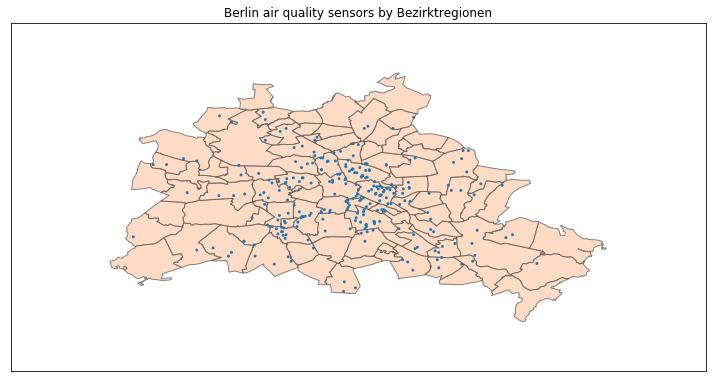

In [22]:
cm = plt.get_cmap('Pastel2')
#num_colours = len(berlin_geo)
 
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = berlin_geo.bounds
w, h = maxx - minx, maxy - miny
ax.set_xlim(minx - 0.2 * w, maxx + 0.2 * w)
ax.set_ylim(miny - 0.2 * h, maxy + 0.2 * h)
ax.set_aspect(1)


bezirktregionen_patches = []
for p in berlin_bezirktregionen_polygons:
    colour = cm(1)
    bezirktregionen_patches.append(PolygonPatch(p, fc=colour, ec='#555555', alpha=0.7, zorder=0.5))

for sensor in points:
    p = Circle((sensor.x, sensor.y), 0.002)
    ax.add_patch(p)
    
ax.add_collection(PatchCollection(bezirktregionen_patches, match_original=True))
ax.set_xticks([])
ax.set_yticks([])
plt.title("Berlin air quality sensors by Bezirktregionen")
plt.tight_layout()



plt.show()

## Finally we find the closest weather station to each sensor

In [23]:
closest_weather_stations=[]
for sensor in berlin_sensors:
    coords=np.asarray(sensor[1:3]).astype(np.float)
    s=utils.get_closest_weather_station(float(coords[1]),float(coords[0]),credentials_1)
    l=s[0].get_location()
    closest_weather_stations.append([sensor[0],sensor[1],sensor[2],sensor[3],l.get_name(),l.get_lon(),l.get_lat()])
